In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.metrics import confusion_matrix, make_scorer, roc_auc_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from itertools import product
from sklearn.pipeline import Pipeline
import pickle
import glob

# WIND SPEED PROBLEM

In [3]:
def apply_vif(df_test, var_names, verbose=False):
    
    for var in var_names:

        if var in df_test.columns:

            y = df_test[var]
            X = df_test[df_test.columns].drop(columns=[var])
            
            r_squared = np.linalg.lstsq(X, y, rcond=None)[0]
            vif = 1.0 / (1.0 - r_squared)
            
            cols_drop = list(pd.DataFrame(vif, columns=['vif']).sort_values(by='vif', ascending=False).query("vif >= 5").reset_index()['index'])
            
            if len(cols_drop) >  0:
                cols_drop_df = list(X.columns[cols_drop])
                if verbose:
                    print(f"{var}, Columnas a eliminar: {cols_drop_df}")
                df_test = df_test.drop(cols_drop_df, axis=1)
            
    return df_test

In [4]:
df_dv_test = pd.read_csv('data_teste_dv_df_2011.csv')
df_dv_train = pd.read_csv('data_treino_dv_df_2000_2010.csv')
df_dv_train

,HORA (UTC),"VENTO, DIREï¿½ï¿½O HORARIA (gr) (ï¿½ (gr))","VENTO, VELOCIDADE HORARIA (m/s)",UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),TEMPERATURA Mï¿½XIMA NA HORA ANT. (AUT) (ï¿½C),TEMPERATURA Mï¿½NIMA NA HORA ANT. (AUT) (ï¿½C),"UMIDADE RELATIVA DO AR, HORARIA (%)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)","PRECIPITAï¿½ï¿½O TOTAL, HORï¿½RIO (mm)","VENTO, RAJADA MAXIMA (m/s)",PRESSï¿½O ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSï¿½O ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)
0,12:00,0.809017,1.8,69.0,60.0,22.6,20.7,61.0,888.2,0.0,3.8,888.2,887.7
1,13:00,0.965926,2.7,62.0,55.0,24.2,22.5,55.0,888.4,0.0,4.7,888.4,888.2
2,14:00,0.891007,2.0,56.0,50.0,25.5,24.3,51.0,888.1,0.0,4.9,888.4,888.1
3,15:00,0.848048,2.5,52.0,44.0,27.4,25.0,44.0,887.4,0.0,5.8,888.1,887.4
4,16:00,0.224951,2.4,50.0,43.0,27.1,25.5,46.0,886.5,0.0,5.8,887.4,886.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
87688,19:00,-0.615661,5.6,83.0,78.0,21.8,21.1,80.0,879.1,0.0,12.3,879.8,879.1
87689,20:00,-0.469472,4.9,84.0,79.0,21.7,21.0,84.0,879.2,0.0,9.9,879.2,878.9
87690,21:00,-0.484810,4.5,86.0,82.0,21.2,20.6,86.0,879.7,0.0,8.9,879.8,879.2
87691,22:00,-0.484810,3.2,88.0,85.0,20.6,20.2,88.0,880.5,0.0,8.0,880.5,879.6


In [5]:
df_dv_train.columns

Index(['HORA (UTC)', 'VENTO, DIREï¿½ï¿½O HORARIA (gr) (ï¿½ (gr))',
       'VENTO, VELOCIDADE HORARIA (m/s)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'TEMPERATURA Mï¿½XIMA NA HORA ANT. (AUT) (ï¿½C)',
       'TEMPERATURA Mï¿½NIMA NA HORA ANT. (AUT) (ï¿½C)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRECIPITAï¿½ï¿½O TOTAL, HORï¿½RIO (mm)', 'VENTO, RAJADA MAXIMA (m/s)',
       'PRESSï¿½O ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSï¿½O ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)'],
      dtype='object')

Vemos que las columnas tienen nombres extensos y en otro idioma, los cambiamos a nombres mas entendibles

In [6]:
dict_names = {df_dv_train.columns[0]: 'hour',
            df_dv_train.columns[1]: 'wind_direction',
            df_dv_train.columns[2]: 'wind_speed',
            df_dv_train.columns[3]:'humidity_max',
            df_dv_train.columns[4]:'humidity_min',
            df_dv_train.columns[5]:'temperature_max',
            df_dv_train.columns[6]:'temperature_min',
            df_dv_train.columns[7]:'relative_air_humidity',
            df_dv_train.columns[8]:'atmospheric_pressure_season',
            df_dv_train.columns[9]:'total_precipitation',
            df_dv_train.columns[10]:'wind_crack_max',
            df_dv_train.columns[11]:'atmospheric_pressure_max',
            df_dv_train.columns[12]:'atmospheric_pressure_min'}

df_dv_train.rename(columns=dict_names, inplace=True)
df_dv_test.rename(columns=dict_names, inplace=True)

In [7]:
df_dv_train.shape, df_dv_test.shape

((87693, 13), (8726, 13))

In [8]:
df_dv_train.dtypes

hour                            object
wind_direction                 float64
wind_speed                     float64
humidity_max                   float64
humidity_min                   float64
temperature_max                float64
temperature_min                float64
relative_air_humidity          float64
atmospheric_pressure_season    float64
total_precipitation            float64
wind_crack_max                 float64
atmospheric_pressure_max       float64
atmospheric_pressure_min       float64
dtype: object

Todas son variables numericas a excepcion de la hora que es categorica

In [9]:
counts_nan = pd.concat([pd.DataFrame(df_dv_train.isnull().sum(), columns=['nan_values']), pd.DataFrame((df_dv_train.isnull().sum() / len(df_dv_train)) * 100, columns=['perct_nan_values'])], axis=1).sort_values(by='perct_nan_values', ascending=False)
counts_nan

,nan_values,perct_nan_values
hour,0,0.0
wind_direction,0,0.0
wind_speed,0,0.0
humidity_max,0,0.0
humidity_min,0,0.0
temperature_max,0,0.0
temperature_min,0,0.0
relative_air_humidity,0,0.0
atmospheric_pressure_season,0,0.0
total_precipitation,0,0.0


No hay valores nulos en ninguna columna

In [10]:
df_dv_train.describe()

,wind_direction,wind_speed,humidity_max,humidity_min,temperature_max,temperature_min,relative_air_humidity,atmospheric_pressure_season,total_precipitation,wind_crack_max,atmospheric_pressure_max,atmospheric_pressure_min
count,87693.000000,87693.000000,87693.000000,87693.000000,87693.000000,87693.000000,87693.000000,87693.000000,87693.000000,87693.000000,87693.000000,87693.000000
mean,0.405810,2.466192,69.058465,63.176194,21.921264,20.684570,66.146682,887.251925,0.160907,5.161076,887.580724,886.891093
std,0.686247,1.313968,19.640222,20.166336,3.721386,3.513744,19.992327,4.012404,1.307515,2.311157,3.646750,3.564539
min,-1.000000,0.000000,12.000000,10.000000,9.200000,8.400000,10.000000,863.400000,0.000000,0.000000,865.300000,862.800000
25%,-0.156434,1.500000,54.000000,48.000000,19.200000,18.400000,51.000000,885.300000,0.000000,3.400000,885.600000,885.000000
50%,0.788011,2.400000,72.000000,64.000000,21.400000,20.200000,68.000000,887.200000,0.000000,5.000000,887.500000,886.900000
75%,0.970296,3.400000,87.000000,80.000000,24.700000,23.100000,84.000000,889.100000,0.000000,6.800000,889.300000,888.800000
max,1.000000,10.000000,100.000000,98.000000,35.300000,34.400000,99.000000,1023.500000,70.800000,24.300000,913.100000,910.900000


In [22]:
eda_vars = ['wind_speed', 'wind_direction', 'humidity_max', 'temperature_max', 'relative_air_humidity', 'atmospheric_pressure_season']

<Axes: >

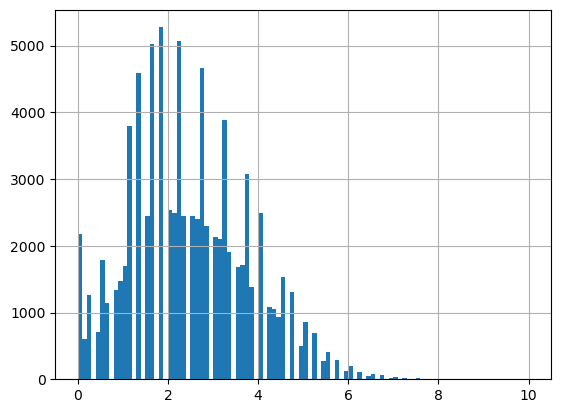

In [11]:
df_dv_train['wind_speed'].hist(bins=100)


La variable wind speed tiene una distribucion con un sesgo a la derecha y es asimetrica a la izquierda. Se encuentra entre valores de 0 y 10. 

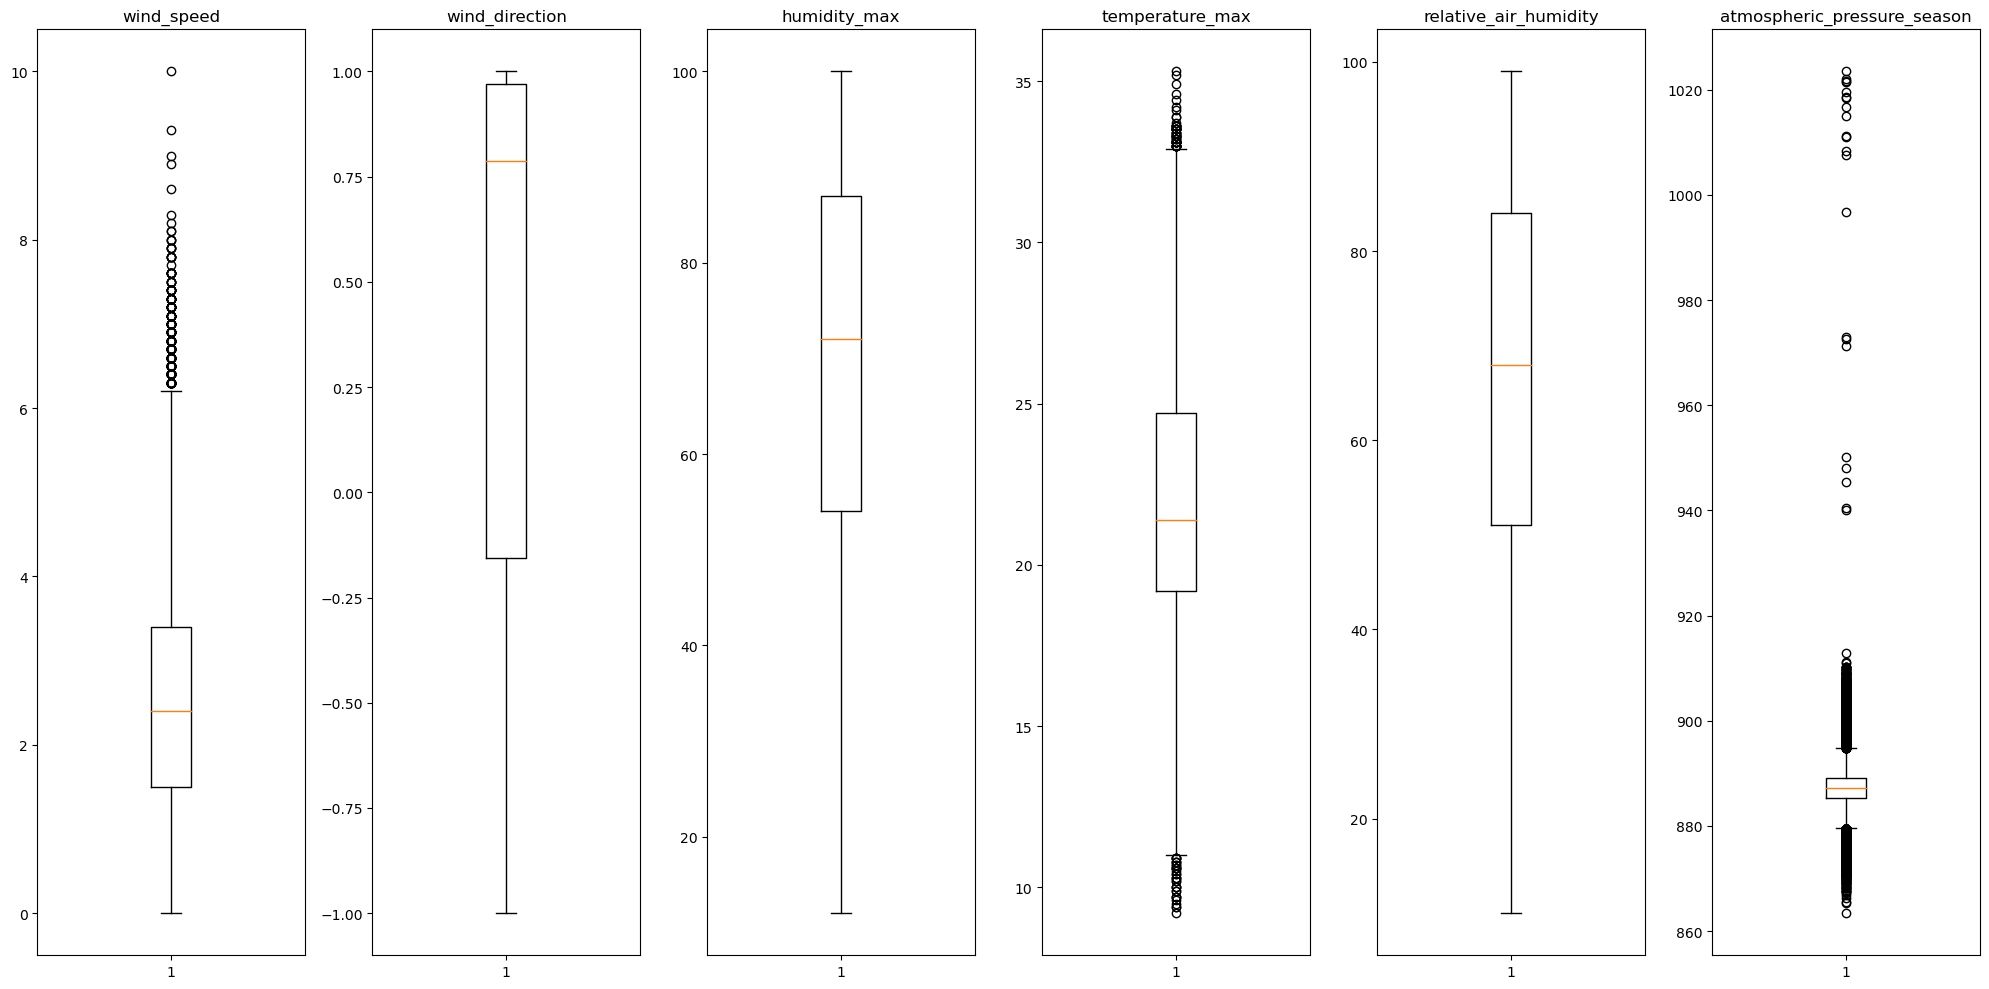

In [23]:
fig, axes = plt.subplots(1, len(eda_vars), figsize=(20, 10))
for i, col in enumerate(eda_vars):
    axes[i].boxplot(df_dv_train[col])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

Al ver los boxplots de la variable se puede ver la simetria de cada una de estas y los valores atipicos, para las variables wind speed se ven bastantes valores atipicos hacia arriba, en temperature max y atmospheric pressure de los dos lados. Algunas variables como wind_speed, wind_direction, humidity_max y relative_air_humidity parecen tener un sesgo.

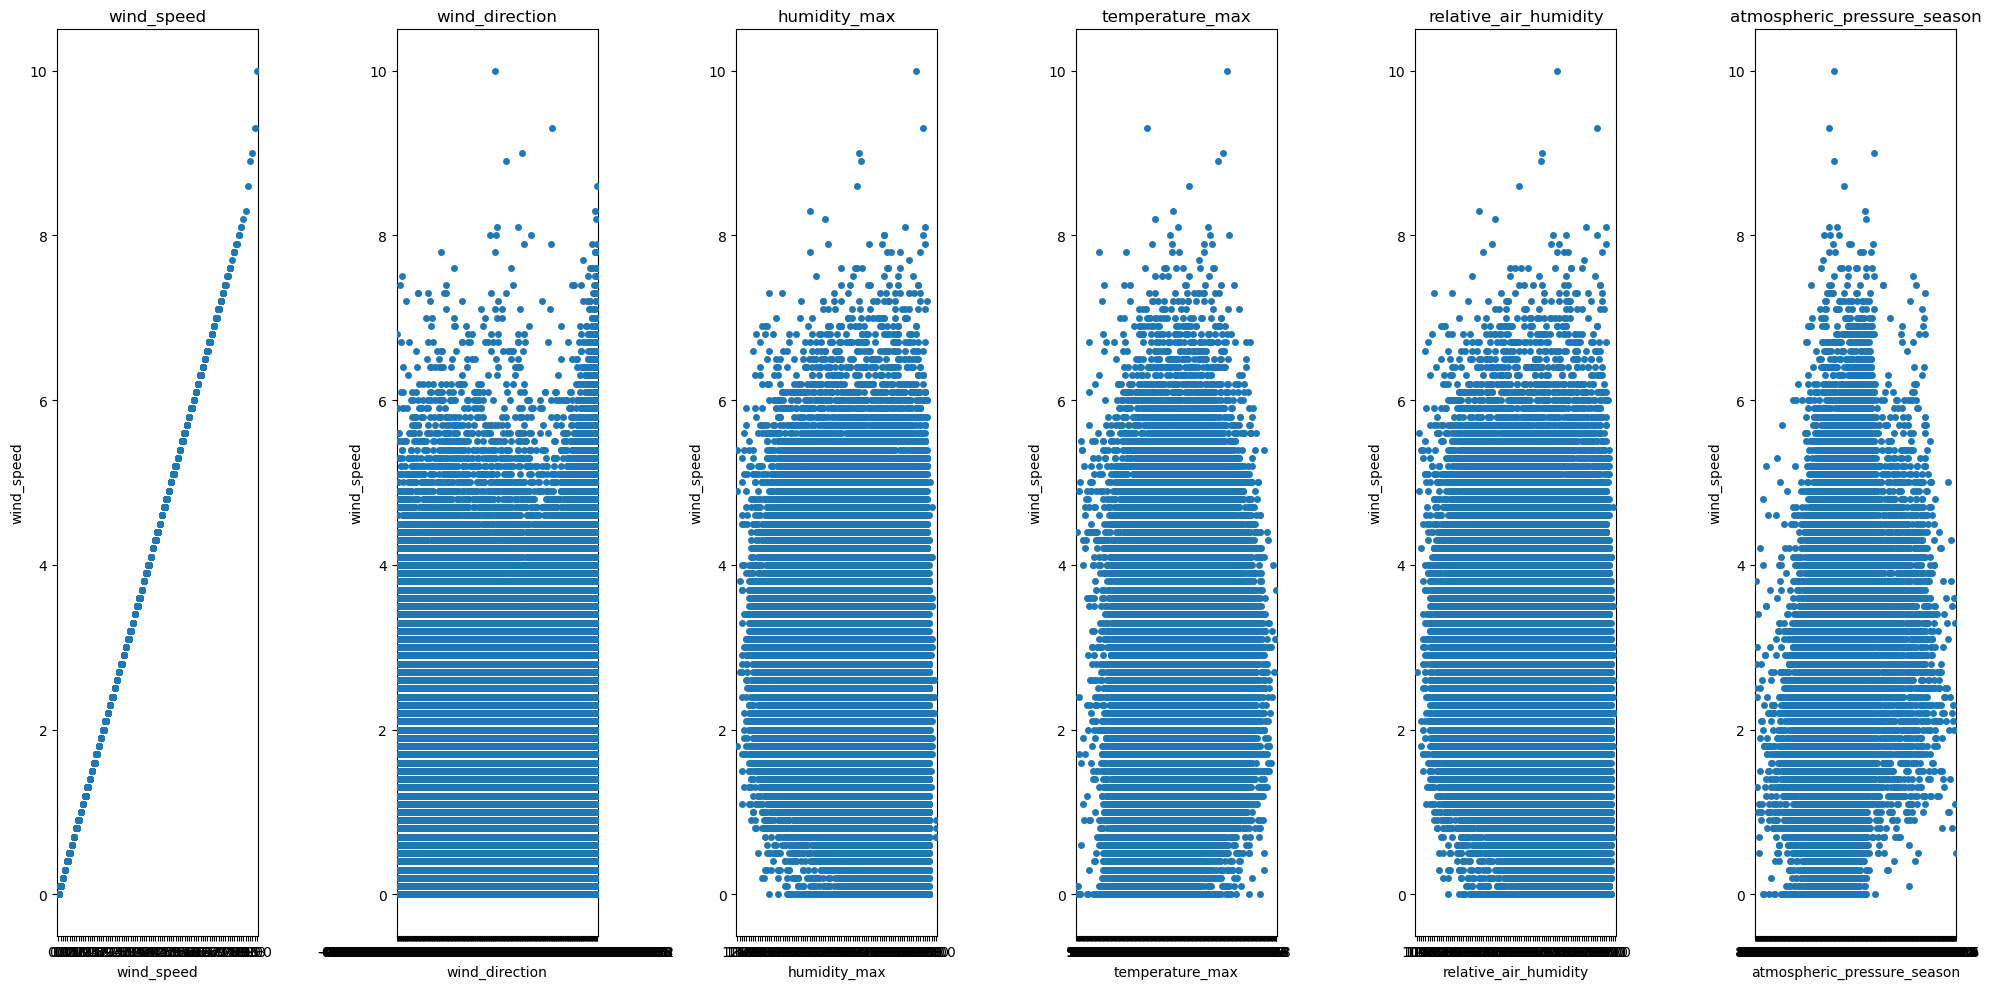

In [24]:
fig, axes = plt.subplots(1, len(eda_vars), figsize=(20, 10))
for i, col in enumerate(eda_vars):
    sns.stripplot(y="wind_speed", x=col, data=df_dv_train, jitter=True, edgecolor="gray", ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

Al hacer el analisis de las variables con la variable respuesta, parece no haber un patron entre estas.

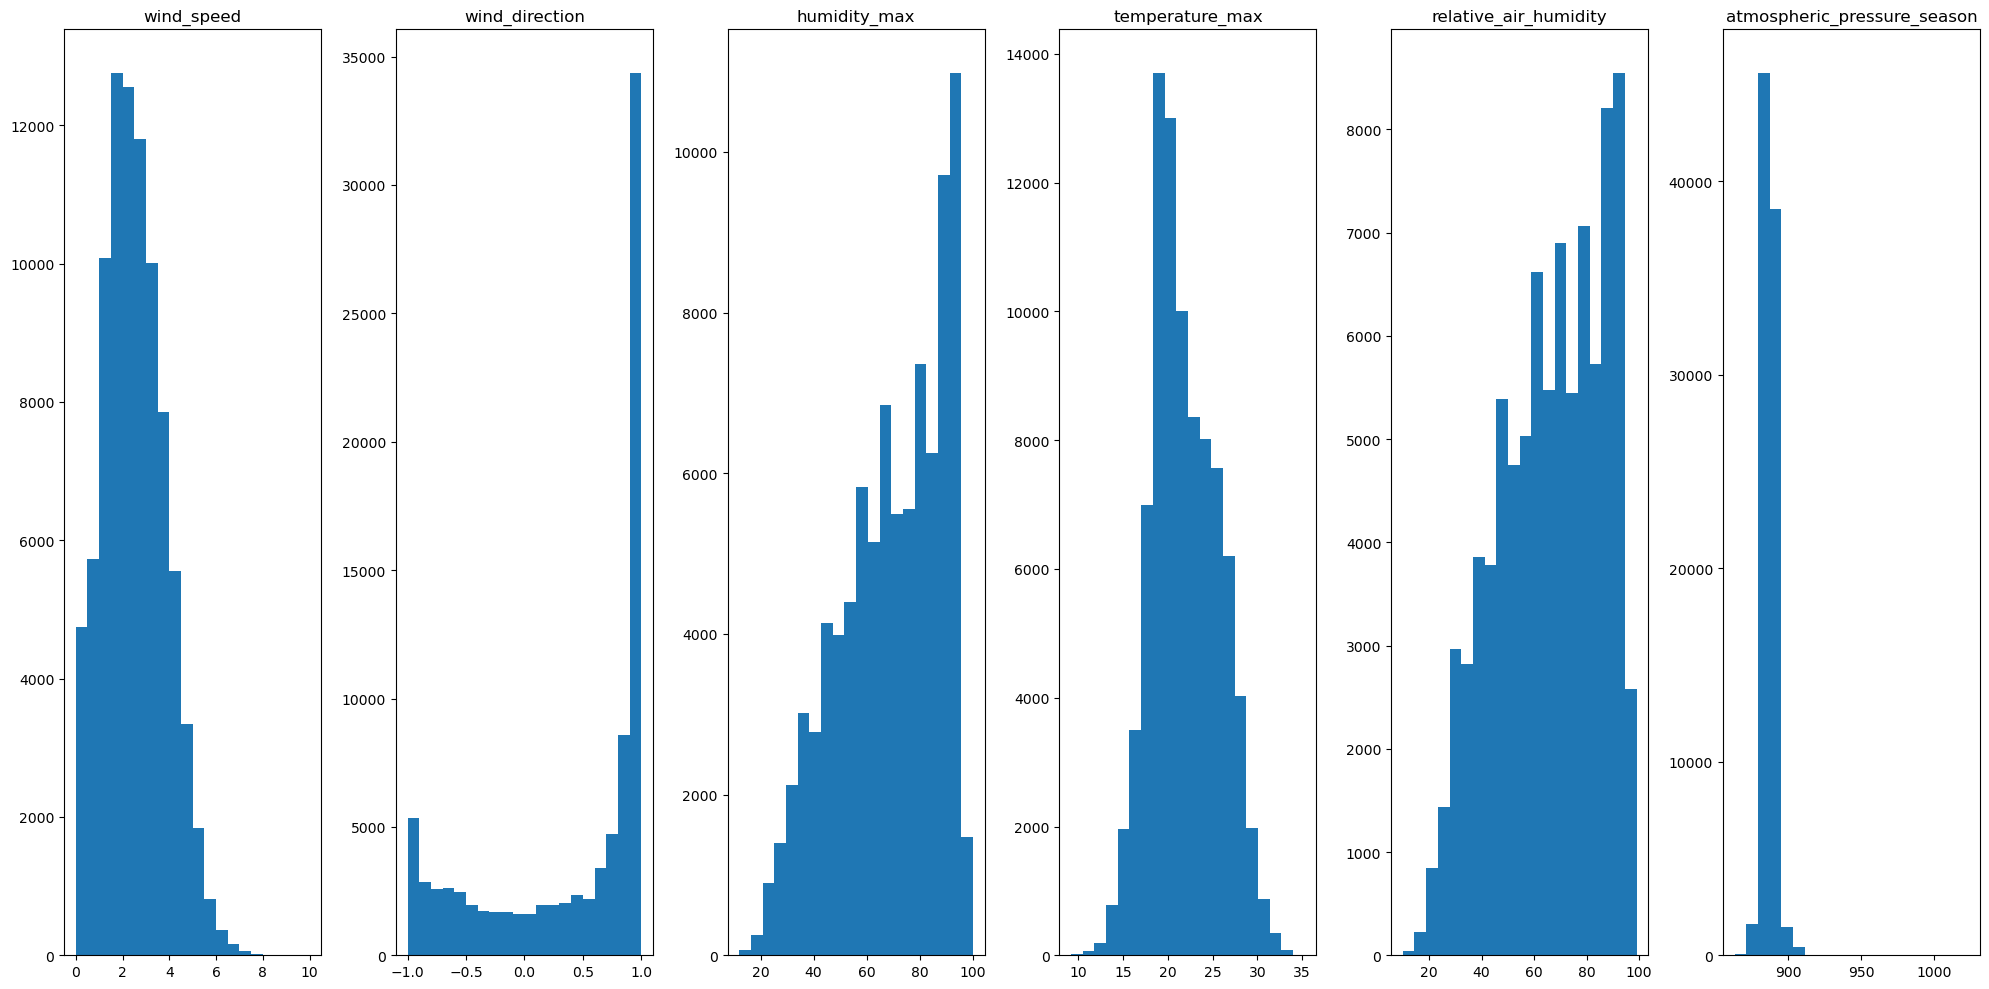

In [25]:
fig, axes = plt.subplots(1, len(eda_vars), figsize=(20, 10))
for i, col in enumerate(eda_vars):
    axes[i].hist(df_dv_train[col], bins=20)
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

Como se veia en los boxplots las distribuciones de las variables no es simetrica, wind_speed tiene un sesgo a la derecha, wind_direction parece ser un poco uniforme, humidity_max y relative_air tienen un sesgo a la izquierda y temperatura maxima tiene un ligero sesgo a la derecha.

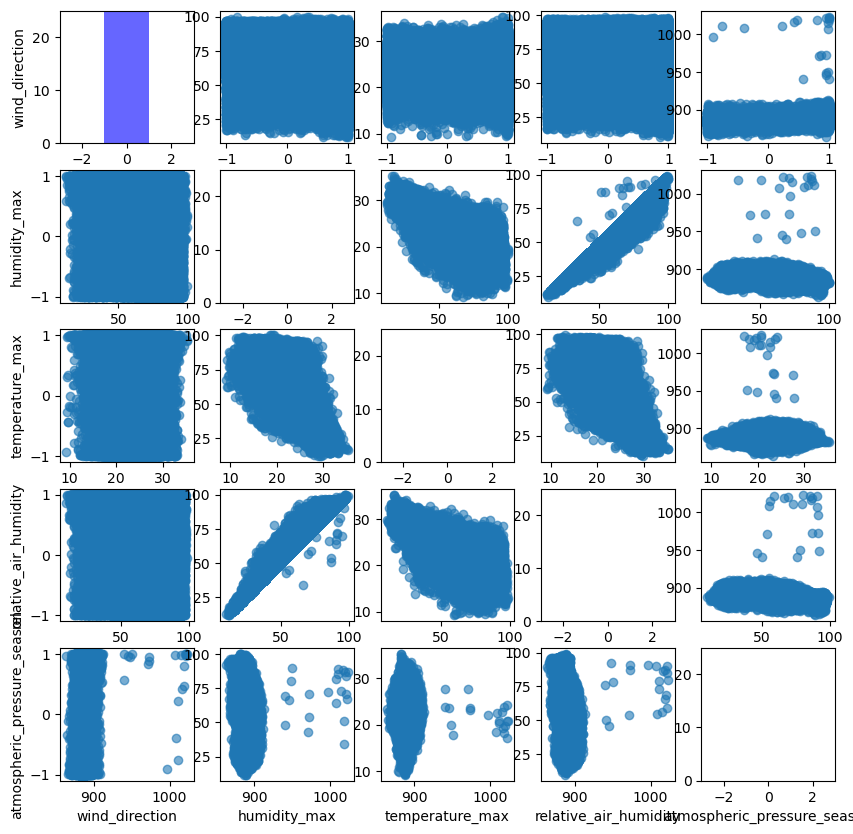

In [21]:
fig, axes = plt.subplots(len(eda_vars), len(eda_vars), figsize=(10, 10))

for i in range(len(eda_vars)):
    for j in range(len(eda_vars)):
        if i == j:
            # Si es la misma variable en ambas dimensiones, crea un histograma en su lugar
            axes[i, j].hist(df_dv_train[eda_vars[i]], bins=15, color='b', alpha=0.6)
            axes[i, j].set_xlim(-3, 3)
            axes[i, j].set_ylim(0, 25)
        else:
            # Si son variables diferentes, crea un gráfico de dispersión
            axes[i, j].scatter(df_dv_train[eda_vars[i]], df_dv_train[eda_vars[j]], alpha=0.6)

        if i == len(eda_vars)-1:
            axes[i, j].set_xlabel(eda_vars[j])
        if j == 0:
            axes[i, j].set_ylabel(eda_vars[i])

Aca podemos ver el analisis bivariado de las variables, en algunas se observa una relacion y patrones.

In [10]:
df_vif = df_dv_train.drop("hour", axis=1)
df_vif = apply_vif(df_vif, df_vif.columns, verbose=True)

temperature_max, Columnas a eliminar: ['temperature_min']
atmospheric_pressure_max, Columnas a eliminar: ['atmospheric_pressure_min']


In [11]:
df_vif['hour'] = df_dv_train['hour']
df_dv_train = df_vif.copy()
df_dv_test.drop(['temperature_min', 'atmospheric_pressure_min'], axis=1, inplace=True)

Se eliminan las variables altamente correlacionadas utilizando la metrica del VIF > 5.

In [12]:
X_train, X_test = df_dv_train.drop(columns=['wind_speed', 'hour']), df_dv_test.drop(columns=['wind_speed', 'hour'])
y_train, y_test = df_dv_train['wind_speed'], df_dv_test['wind_speed']

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((87693, 9), (8726, 9), (87693,), (8726,))

In [11]:
def get_bestmodel_knn(param_grid, intervals, X_train_full, y_train_full, verbose=False):
    
    comb_param = list(product(*param_grid.values()))

    results = []
    for i in intervals:
        
        best_score = -np.inf
        
        X_val, y_val = X_train_full[-i:], y_train_full[-i:]
        X_train, y_train = X_train_full[:-i], y_train_full[:-i]

        for param in comb_param:
            
            params = {key: value for key, value in zip(param_grid.keys(), param)}
            
            pipe = Pipeline([
            ('scaler', MinMaxScaler()), 
            ('knn', KNeighborsRegressor(**params))])
            
            pipe.fit(X_train, y_train)
            
            y_pred = pipe.predict(X_val)
            score = mean_squared_error(y_val, y_pred)**2
            
            if score > best_score:
                best_score = score
                best_parameters = params

        best_parameters['interval'] = i
        best_parameters['best_score'] = best_score
        results.append(best_parameters)
        if verbose:
            print("Best parameters: ", best_parameters, ", Best score: ", best_score)
        
    best_results = max(results, key=lambda x: x['best_score'])
    best_params = copy.deepcopy(best_results)
    del best_params['interval']
    del best_params['best_score']
    best_interval = best_results['interval']
    
    return results, best_results, best_params, best_interval

In [13]:
model_knn = None
if (len(glob.glob("knn_model_reg.pkl")) != 0):
    
     model_knn = pickle.load(open('knn_model_reg.pkl','rb'))
     
else:
     
     param_grid = {'n_neighbors': [5, 6, 7, 8, 9, 10],
          'weights': ['uniform', 'distance'],
          'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
          'leaf_size': [10, 20, 30],
          'p': [1, 2]}

     intervals = [24, 48, 72, 96, 120]

     results_knn, best_results_knn, best_params_knn, best_interval_knn = get_bestmodel_knn(param_grid, intervals, X_train, y_train, verbose=True)

     model_knn = Pipeline([
          ('scaler', MinMaxScaler()), 
          ('knn', KNeighborsRegressor(**best_params_knn))])
          
     model_knn.fit(X_train, y_train)
     
     pickle.dump(model_knn, open('knn_model_reg.pkl', 'wb'))

# KNN

[{'Model': 'KNN', 'rmse': 0.10204289637902905, 'mape': 0.24414886774593536, 'r2': 0.7772431449865318}]


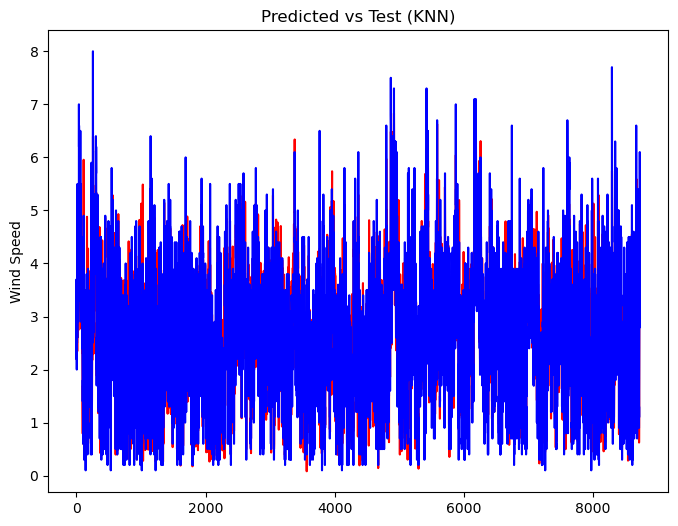

In [28]:
y_pred_knn = model_knn.predict(X_test)
rmse, mape, r2 = mean_squared_error(y_test, y_pred_knn)**2, mean_absolute_percentage_error(y_test, y_pred_knn), r2_score(y_test, y_pred_knn)
results_metrics = [{"Model":'KNN', "rmse":rmse, "mape":mape,"r2":r2}]
print(results_metrics)

# Plot y_pred vs y_test
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(y_pred_knn)), y_pred_knn, color='red', label='Predicted')
plt.plot(np.arange(len(y_test)), y_test, color='blue', label='Test')

plt.ylabel('Wind Speed')
plt.title('Predicted vs Test (KNN)')

plt.show()

# RIDGE

In [14]:
def get_bestmodel_ridge(param_grid, intervals, X_train_full, y_train_full, verbose=False):
    
    comb_param = list(product(*param_grid.values()))

    results = []
    for i in intervals:
        
        best_score = -np.inf
        
        X_val, y_val = X_train_full[-i:], y_train_full[-i:]
        X_train, y_train = X_train_full[:-i], y_train_full[:-i]

        for param in comb_param:
            
            params = {key: value for key, value in zip(param_grid.keys(), param)}
            
            pipe = Pipeline([
            ('scaler', MinMaxScaler()), 
            ('ridge', Ridge(**params))])
            
            pipe.fit(X_train, y_train)
            
            y_pred = pipe.predict(X_val)
            score = mean_squared_error(y_val, y_pred)**2
            
            if score > best_score:
                best_score = score
                best_parameters = params

        best_parameters['interval'] = i
        best_parameters['best_score'] = best_score
        results.append(best_parameters)
        if verbose:
            print("Best parameters: ", best_parameters, ", Best score: ", best_score)
        
    best_results = max(results, key=lambda x: x['best_score'])
    best_params = copy.deepcopy(best_results)
    del best_params['interval']
    del best_params['best_score']
    best_interval = best_results['interval']
    
    return results, best_results, best_params, best_interval

In [15]:
model_ridge = None
if (len(glob.glob("ridge_model_reg.pkl")) != 0):
    
    model_ridge = pickle.load(open('ridge_model_reg.pkl','rb'))
     
else:
     
    param_grid = {'alpha': [0.1, 0.5, 1, 5, 10],
                'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'saga']}

    intervals = [24, 48, 72, 96, 120]

    results_ridge, best_results_ridge, best_params_ridge, best_interval_ridge = get_bestmodel_ridge(param_grid, intervals, X_train, y_train, verbose=True)

    model_ridge = Pipeline([
        ('scaler', MinMaxScaler()), 
        ('ridge', Ridge(**best_params_ridge))])
        
    model_ridge.fit(X_train, y_train)
    
    pickle.dump(model_ridge, open('ridge_model_reg.pkl', 'wb'))

[{'Model': 'KNN', 'rmse': 0.10204289637902905, 'mape': 0.24414886774593536, 'r2': 0.7772431449865318}, {'Model': 'Ridge', 'rmse': 0.1005876195153101, 'mape': 0.24658171342068458, 'r2': 0.7788372638148204}]


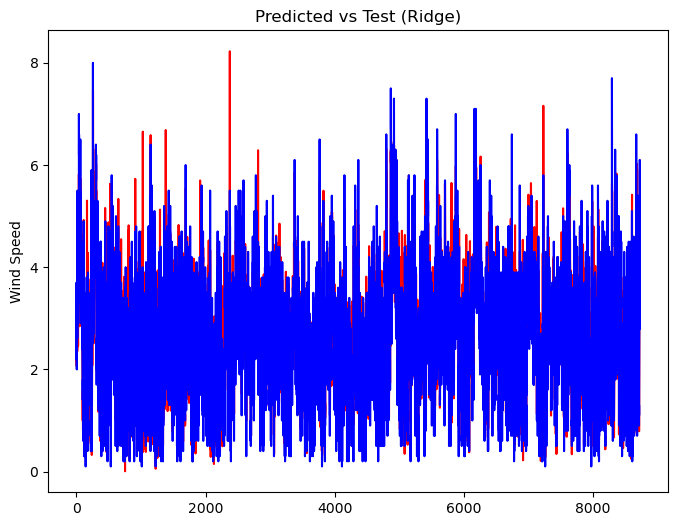

In [29]:
y_pred_ridge = model_ridge.predict(X_test)
rmse, mape, r2 = mean_squared_error(y_test, y_pred_ridge)**2, mean_absolute_percentage_error(y_test, y_pred_ridge), r2_score(y_test, y_pred_ridge)
results_metrics.append({"Model":'Ridge', "rmse":rmse, "mape":mape,"r2":r2})
print(results_metrics)

# Plot y_pred vs y_test
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(y_pred_ridge)), y_pred_ridge, color='red', label='Predicted')
plt.plot(np.arange(len(y_test)), y_test, color='blue', label='Test')

plt.ylabel('Wind Speed')
plt.title('Predicted vs Test (Ridge)')

plt.show()

# LASSO

In [17]:
def get_bestmodel_lasso(param_grid, intervals, X_train_full, y_train_full, verbose=False):
    
    comb_param = list(product(*param_grid.values()))

    results = []
    for i in intervals:
        
        best_score = -np.inf
        
        X_val, y_val = X_train_full[-i:], y_train_full[-i:]
        X_train, y_train = X_train_full[:-i], y_train_full[:-i]

        for param in comb_param:
            
            params = {key: value for key, value in zip(param_grid.keys(), param)}
            
            pipe = Pipeline([
            ('scaler', MinMaxScaler()), 
            ('lasso', Lasso(**params))])
            
            pipe.fit(X_train, y_train)
            
            y_pred = pipe.predict(X_val)
            score = mean_squared_error(y_val, y_pred)**2
            
            if score > best_score:
                best_score = score
                best_parameters = params

        best_parameters['interval'] = i
        best_parameters['best_score'] = best_score
        results.append(best_parameters)
        if verbose:
            print("Best parameters: ", best_parameters, ", Best score: ", best_score)
        
    best_results = max(results, key=lambda x: x['best_score'])
    best_params = copy.deepcopy(best_results)
    del best_params['interval']
    del best_params['best_score']
    best_interval = best_results['interval']
    
    return results, best_results, best_params, best_interval

In [18]:
model_lasso = None
if (len(glob.glob("lasso_model_reg.pkl")) != 0):
    
    model_lasso = pickle.load(open('lasso_model_reg.pkl','rb'))
     
else:
     
    param_grid = {'alpha': [0.1, 0.5, 1, 5, 10],
                'selection': ['cyclic', 'random']}

    intervals = [24, 48, 72, 96, 120]

    results_lasso, best_results_lasso, best_params_lasso, best_interval_lasso = get_bestmodel_lasso(param_grid, intervals, X_train, y_train, verbose=True)

    model_lasso = Pipeline([
        ('scaler', MinMaxScaler()), 
        ('lasso', Lasso(**best_params_lasso))])
        
    model_lasso.fit(X_train, y_train)
    
    pickle.dump(model_lasso, open('lasso_model_reg.pkl', 'wb'))

[{'Model': 'KNN', 'rmse': 0.10204289637902905, 'mape': 0.24414886774593536, 'r2': 0.7772431449865318}, {'Model': 'Ridge', 'rmse': 0.1005876195153101, 'mape': 0.24658171342068458, 'r2': 0.7788372638148204}, {'Model': 'Lasso', 'rmse': 1.578731398419847, 'mape': 0.6189083201209884, 'r2': 0.12381903810901485}]


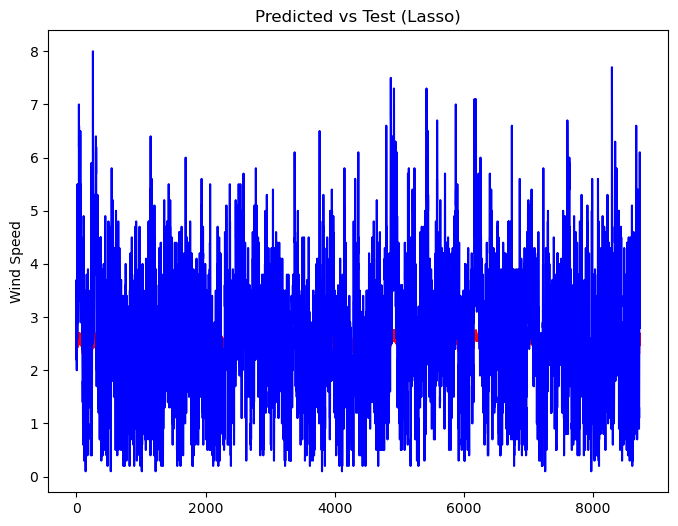

In [30]:
y_pred_lasso = model_lasso.predict(X_test)
rmse, mape, r2 = mean_squared_error(y_test, y_pred_lasso)**2, mean_absolute_percentage_error(y_test, y_pred_lasso), r2_score(y_test, y_pred_lasso)
results_metrics.append({"Model":'Lasso', "rmse":rmse, "mape":mape,"r2":r2})
print(results_metrics)

# Plot y_pred vs y_test
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(y_pred_lasso)), y_pred_lasso, color='red', label='Predicted')
plt.plot(np.arange(len(y_test)), y_test, color='blue', label='Test')

plt.ylabel('Wind Speed')
plt.title('Predicted vs Test (Lasso)')

plt.show()

# XGBOOST

In [22]:
def get_bestmodel_xgb(param_grid, intervals, X_train_full, y_train_full, verbose=False):
    
    comb_param = list(product(*param_grid.values()))

    results = []
    for i in intervals:
        
        best_score = -np.inf
        
        X_val, y_val = X_train_full[-i:], y_train_full[-i:]
        X_train, y_train = X_train_full[:-i], y_train_full[:-i]

        for param in comb_param:
            
            params = {key: value for key, value in zip(param_grid.keys(), param)}
            
            pipe = Pipeline([('xgb', XGBRegressor(**params))])
            
            pipe.fit(X_train, y_train)
            
            y_pred = pipe.predict(X_val)
            score = mean_squared_error(y_val, y_pred)**2
            
            if score > best_score:
                best_score = score
                best_parameters = params

        best_parameters['interval'] = i
        best_parameters['best_score'] = best_score
        results.append(best_parameters)
        if verbose:
            print("Best parameters: ", best_parameters, ", Best score: ", best_score)
        
    best_results = max(results, key=lambda x: x['best_score'])
    best_params = copy.deepcopy(best_results)
    del best_params['interval']
    del best_params['best_score']
    best_interval = best_results['interval']
    
    return results, best_results, best_params, best_interval

In [20]:
model_xgb = None
if (len(glob.glob("xgb_model_reg.pkl")) != 0):
    
    model_xgb = pickle.load(open('xgb_model_reg.pkl','rb'))
     
else:
     
    param_grid = {'n_estimators': [100, 500, 1000],
                    'max_depth': [3, 5, 10],
                    'learning_rate': [0.001, 0.01, 0.1]}

    intervals = [24, 48, 72, 96, 120]

    results_xgb, best_results_xgb, best_params_xgb, best_interval_xgb = get_bestmodel_xgb(param_grid, intervals, X_train, y_train, verbose=True)

    model_xgb = Pipeline([('xgb', XGBRegressor(**best_params_xgb))])
        
    model_xgb.fit(X_train, y_train)
    
    pickle.dump(model_xgb, open('xgb_model_reg.pkl', 'wb'))

[{'Model': 'KNN', 'rmse': 0.10204289637902905, 'mape': 0.24414886774593536, 'r2': 0.7772431449865318}, {'Model': 'Ridge', 'rmse': 0.1005876195153101, 'mape': 0.24658171342068458, 'r2': 0.7788372638148204}, {'Model': 'Lasso', 'rmse': 1.578731398419847, 'mape': 0.6189083201209884, 'r2': 0.12381903810901485}, {'Model': 'XGBoost', 'rmse': 0.08273198152124493, 'mape': 0.23078446592151586, 'r2': 0.7994251840890807}]


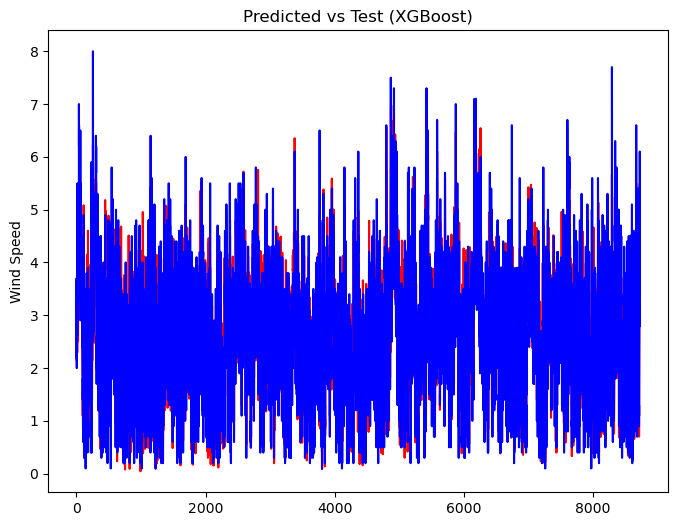

In [31]:
y_pred_xgb = model_xgb.predict(X_test)
rmse, mape, r2 = mean_squared_error(y_test, y_pred_xgb)**2, mean_absolute_percentage_error(y_test, y_pred_xgb), r2_score(y_test, y_pred_xgb)
results_metrics.append({"Model":'XGBoost', "rmse":rmse, "mape":mape,"r2":r2})
print(results_metrics)

# Plot y_pred vs y_test
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(y_pred_xgb)), y_pred_xgb, color='red', label='Predicted')
plt.plot(np.arange(len(y_test)), y_test, color='blue', label='Test')

plt.ylabel('Wind Speed')
plt.title('Predicted vs Test (XGBoost)')

plt.show()

# SVM

In [25]:
def get_bestmodel_svm(param_grid, intervals, X_train_full, y_train_full, verbose=False):
    
    comb_param = list(product(*param_grid.values()))

    results = []
    for i in intervals:
        
        best_score = -np.inf
        
        X_val, y_val = X_train_full[-i:], y_train_full[-i:]
        X_train, y_train = X_train_full[:-i], y_train_full[:-i]

        for param in comb_param:
            
            params = {key: value for key, value in zip(param_grid.keys(), param)}
            
            pipe = Pipeline([
                            ('scaler', MinMaxScaler()), 
                            ('svm', SVR(**params))])
            
            pipe.fit(X_train, y_train)
            
            y_pred = pipe.predict(X_val)
            score = mean_squared_error(y_val, y_pred)**2
            
            if score > best_score:
                best_score = score
                best_parameters = params

        best_parameters['interval'] = i
        best_parameters['best_score'] = best_score
        results.append(best_parameters)
        if verbose:
            print("Best parameters: ", best_parameters, ", Best score: ", best_score)
        
    best_results = max(results, key=lambda x: x['best_score'])
    best_params = copy.deepcopy(best_results)
    del best_params['interval']
    del best_params['best_score']
    best_interval = best_results['interval']
    
    return results, best_results, best_params, best_interval

In [22]:
model_svm = None
if (len(glob.glob("svm_model_reg.pkl")) != 0):
    
    model_svm = pickle.load(open('svm_model_reg.pkl','rb'))
     
else:
     
    param_grid = {'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                    'svm__degree': [1, 2],
                    'svm__gamma': ['scale', 'auto']}

    intervals = [24, 48, 72, 96]

    results_svm, best_results_svm, best_params_svm, best_interval_svm = get_bestmodel_svm(param_grid, intervals, X_train, y_train, verbose=True)

    model_svm = Pipeline([
                        ('scaler', MinMaxScaler()), 
                        ('svm', SVR(**best_params_svm))])
        
    model_svm.fit(X_train, y_train)
    
    pickle.dump(model_svm, open('svm_model_reg.pkl', 'wb'))

[{'Model': 'KNN', 'rmse': 0.10204289637902905, 'mape': 0.24414886774593536, 'r2': 0.7772431449865318}, {'Model': 'Ridge', 'rmse': 0.1005876195153101, 'mape': 0.24658171342068458, 'r2': 0.7788372638148204}, {'Model': 'Lasso', 'rmse': 1.578731398419847, 'mape': 0.6189083201209884, 'r2': 0.12381903810901485}, {'Model': 'XGBoost', 'rmse': 0.08273198152124493, 'mape': 0.23078446592151586, 'r2': 0.7994251840890807}, {'Model': 'SVM', 'rmse': 0.1186343929905831, 'mape': 0.2549800768083338, 'r2': 0.7598154900217838}]


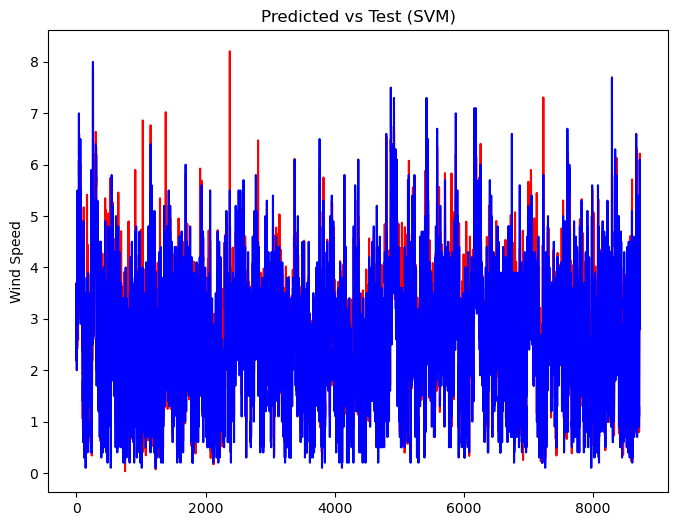

In [32]:
y_pred_svm = model_svm.predict(X_test)
rmse, mape, r2 = mean_squared_error(y_test, y_pred_svm)**2, mean_absolute_percentage_error(y_test, y_pred_svm), r2_score(y_test, y_pred_svm)
results_metrics.append({"Model":'SVM', "rmse":rmse, "mape":mape,"r2":r2})
print(results_metrics)

# Plot y_pred vs y_test
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(y_pred_svm)), y_pred_svm, color='red', label='Predicted')
plt.plot(np.arange(len(y_test)), y_test, color='blue', label='Test')

plt.ylabel('Wind Speed')
plt.title('Predicted vs Test (SVM)')

plt.show()

# MLP

In [24]:
def get_bestmodel_mlp(param_grid, intervals, X_train_full, y_train_full, verbose=False):
    
    comb_param = list(product(*param_grid.values()))

    results = []
    for i in intervals:
        
        best_score = -np.inf
        
        X_val, y_val = X_train_full[-i:], y_train_full[-i:]
        X_train, y_train = X_train_full[:-i], y_train_full[:-i]

        for param in comb_param:
            
            params = {key: value for key, value in zip(param_grid.keys(), param)}
            
            pipe = pipe = Pipeline([
                            ('scaler', MinMaxScaler()), 
                            ('mlp', MLPRegressor(**params))])
            
            pipe.fit(X_train, y_train)
            
            y_pred = pipe.predict(X_val)
            score = mean_squared_error(y_val, y_pred)**2
            
            if score > best_score:
                best_score = score
                best_parameters = params

        best_parameters['interval'] = i
        best_parameters['best_score'] = best_score
        results.append(best_parameters)
        if verbose:
            print("Best parameters: ", best_parameters, ", Best score: ", best_score)
        
    best_results = max(results, key=lambda x: x['best_score'])
    best_params = copy.deepcopy(best_results)
    del best_params['interval']
    del best_params['best_score']
    best_interval = best_results['interval']
    
    return results, best_results, best_params, best_interval

In [25]:
model_mlp = None
if (len(glob.glob("mlp_model_reg.pkl")) != 0):
    
    model_mlp = pickle.load(open('mlp_model_reg.pkl','rb'))
     
else:
     
    param_grid = {'hidden_layer_sizes': [(10,), (50,), (100,)],
                    'activation': ['identity', 'logistic', 'relu'],
                    'solver': ['sgd', 'adam']}

    intervals = [24, 48, 72, 96, 120]

    results_mlp, best_results_mlp, best_params_mlp, best_interval_mlp = get_bestmodel_mlp(param_grid, intervals, X_train, y_train, verbose=True)

    model_mlp = Pipeline([
                ('scaler', MinMaxScaler()), 
                ('mlp', MLPRegressor(**best_params_mlp))])
        
    model_mlp.fit(X_train, y_train)
    
    pickle.dump(model_mlp, open('mlp_model_reg.pkl', 'wb'))

[{'Model': 'KNN', 'rmse': 0.10204289637902905, 'mape': 0.24414886774593536, 'r2': 0.7772431449865318}, {'Model': 'Ridge', 'rmse': 0.1005876195153101, 'mape': 0.24658171342068458, 'r2': 0.7788372638148204}, {'Model': 'Lasso', 'rmse': 1.578731398419847, 'mape': 0.6189083201209884, 'r2': 0.12381903810901485}, {'Model': 'XGBoost', 'rmse': 0.08273198152124493, 'mape': 0.23078446592151586, 'r2': 0.7994251840890807}, {'Model': 'SVM', 'rmse': 0.1186343929905831, 'mape': 0.2549800768083338, 'r2': 0.7598154900217838}, {'Model': 'MLP', 'rmse': 0.0832114706132095, 'mape': 0.2255783076145489, 'r2': 0.7988447888837936}]


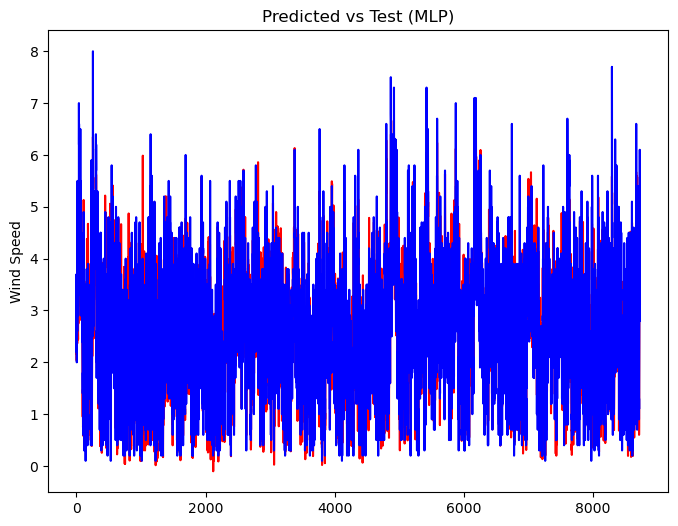

In [33]:
y_pred_mlp = model_mlp.predict(X_test)
rmse, mape, r2 = mean_squared_error(y_test, y_pred_mlp)**2, mean_absolute_percentage_error(y_test, y_pred_mlp), r2_score(y_test, y_pred_mlp)
results_metrics.append({"Model":'MLP', "rmse":rmse, "mape":mape,"r2":r2})
print(results_metrics)

# Plot y_pred vs y_test
plt.figure(figsize=(8, 6))
plt.plot(np.arange(len(y_pred_mlp)), y_pred_mlp, color='red', label='Predicted')
plt.plot(np.arange(len(y_test)), y_test, color='blue', label='Test')

plt.ylabel('Wind Speed')
plt.title('Predicted vs Test (MLP)')

plt.show()

In [34]:
pd.DataFrame(results_metrics)

,Model,rmse,mape,r2
0,KNN,0.102043,0.244149,0.777243
1,Ridge,0.100588,0.246582,0.778837
2,Lasso,1.578731,0.618908,0.123819
3,XGBoost,0.082732,0.230784,0.799425
4,SVM,0.118634,0.254980,0.759815
5,MLP,0.083211,0.225578,0.798845


De la tabla de resultados podemos conluir que el mejor modelo es XGBoost con un RMSE de 0.082, este tambien tiene le mayor r2, este modelo logra explicar la variabilida de los datos en un 79.79%. Este modelo da buenos resultados como metricas de valores aceptables.